## *Components of Time Series* 

You will learn how to investigate and diagnose your time series data to test for specific assumptions such as stationarity and autocorrelation. Finally, the notebook covers practical Methods for transforming your time series data using a family of power transforms, decomposition, and differencing methods.

Additionally, how decompose a time series into its components (trend, seasonality, and residuals), test for different assumptions that your models may rely on (such as stationarity, normality, and homoskedasticity), and explore techniques to transform the data to satisfy some of these assumptions.  

The Methods that you will encounter in this notebook are as follows:
* Decomposing time series data
* Detecting time series stationarity
* Applying power transformations
* Testing for autocorrelation in time series data

### Components of time series: 
Go through this completely: https://www.geeksforgeeks.org/components-of-time-series-data/ 


* Additive vs Mupltiplicative Model: https://youtu.be/K4kFksI1x-w
* Decomposition into Trend, Seasonality and Residual:  https://youtu.be/6iVJPG9RQXQ 

In [1]:
# IMPORTS
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.datasets import co2, get_rdataset

In [3]:
# Specify the path to the CSV file
file = Path('./data/closing_price.csv')

# Read the CSV file into a DataFrame
closing_price = pd.read_csv(file,index_col='Date', parse_dates=True)

# Load the CO2 dataset from statsmodels
co2_df = co2.load_pandas().data

# Forward-fill missing values in the CO2 dataset
co2_df = co2_df.ffill()

# Get the "AirPassengers" dataset from statsmodels
air_passengers = get_rdataset("AirPassengers")

# Extract the data portion from the AirPassengers dataset
airp_df = air_passengers.data

# Set the index of the DataFrame to a date range from '1949' to '1961' with monthly frequency
airp_df.index = pd.date_range('1949', '1961', freq='M')

# Drop the 'time' column from the DataFrame
airp_df.drop(columns=['time'], inplace=True)

# Store the modified DataFrame to a CSV file for future use
airp_df.reset_index().rename(columns={'value':'passengers', 'index':'date'}).to_csv('./data/air_passenger.csv', index=False)

### Decomposing Time Series data
When performing time series analysis, one of your objectives may be forecasting, where 
you build a model to make a future prediction. Before starting the modeling process, you 
will need to extract the components of the time series process for analysis. This will help 
you make informed decisions during the modeling process. In addition, there are three 
major components for any time series process: trend, seasonality, and residual.


* **Trend** gives a sense of the long-term direction of the time series and can be either upward, 
downward, or horizontal. For example, a time series of sales data can show an upward 
(increasing) trend. 
* **Seasonality** is repeated patterns over time. For example, a time series 
of sales data might show an increase in sales around Christmas time. This phenomenon 
can be observed every year (annually) as we approach Christmas. 
* The **residual** is simply 
the remaining or unexplained portion once we extract trend and seasonality.

The decomposition of a time series is the process of extracting the three components and 
representing them as their models. The modeling of the decomposed components can be 
either additive or multiplicative. 
You have an additive model when the original time series can be reconstructed by adding 
all three components:
$$ y_t = T_t + S_t + R_t $$

An additive decomposition model is reasonable when the seasonal variations do 
not change over time. On the other hand, if the time series can be reconstructed by 
multiplying all three components, you have a multiplicative model:
$$ y_t = T_t * S_t * R_t$$

A multiplicative model is suitable when the seasonal variation fluctuates over time. 

Furthermore, you can group these into predictable versus non-predictable components. 
Predictable components are consistent, repeating patterns that can be captured and 
modeled. Seasonality and trend are examples. On the other hand, every time series has an 
unpredictable component that shows irregularity, often called **noise**, though it is referred 
to as **residual** in the context of decomposition. 


In this topic, you will explore different techniques for decomposing your time series 
using the **seasonal_decompose, Seasonal-Trend decomposition with LOESS (STL)**, 
and **hp_filter** methods available in the statsmodels library.

In [4]:
import pandas as pd
import statsmodels as sm
from statsmodels.datasets import elec_equip, co2
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt

In [5]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ##
# plt.rc('font', size=8)                     ## 
# plt.rc('axes', titlesize=16)               ## 
# plt.rc('axes', labelsize=14)               ##
# plt.rc('xtick', labelsize=10)              ##
# plt.rc('ytick', labelsize=10)              ##
# plt.rc('legend', fontsize=10)              ##
# plt.rc('figure', titlesize=12)             ## 
#############################################

### Plot the datasets

You can decompose both datasets using the `seasonal_decompose()` function. 
But before doing so, you should plot your time series first to understand whether 
the seasonality shows **multiplicative** or **additive** behavior:

In [6]:
co2_df.shape

(2284, 1)

In [7]:
co2_df.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

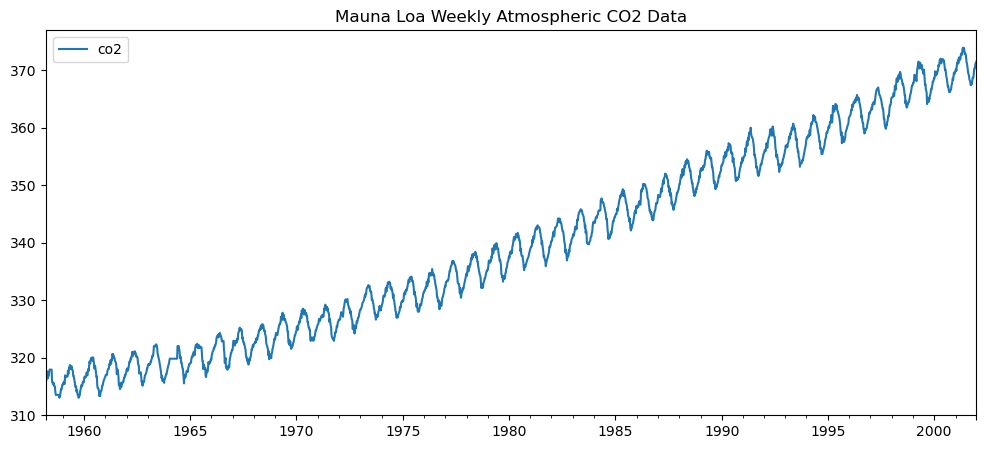

In [8]:
plpt = co2_df.plot(title=co2.TITLE)

his should display a line chart showing weekly carbon dioxide levels measured in 
parts per million (ppm) from 1960 to 2000. When using the `.plot()` method, 
the default chart type is a line chart with the `kind="line"` parameter.

The co2_df data shows a long-term linear (upward) trend, with a repeated 
seasonal pattern at a constant rate (seasonal variation). This indicates that the CO2 
dataset is an **additive model.** 

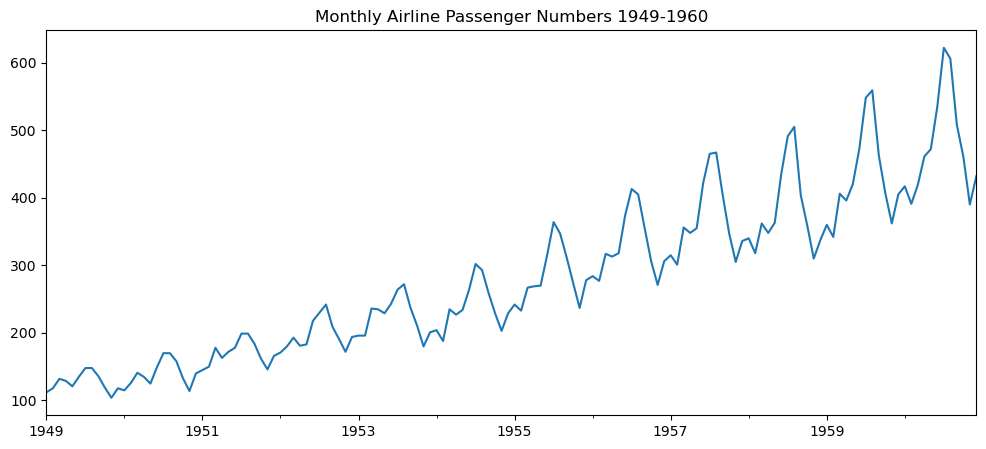

In [9]:
plot = airp_df['value'].plot(title=air_passengers['title'])

This should produce a line chart showing the number of passengers per month from 
1949 to 1960. The airp_df data shows a long-term linear (upward) trend and seasonality. 
However, the seasonality fluctuations seem to be increasing as well, indicating 
a **multiplicative model**.

Use `seasonal_decompose` on the two datasets. For the CO2 data, use an 
additive model and a multiplicative model for the air passenger data:

In [11]:
#plt.rcParams["figure.figsize"] = (11,6)
co2_decomposed = seasonal_decompose(co2_df,model='additive')
air_decomposed = seasonal_decompose(airp_df,model='multiplicative')

Both **co2_decomposed** and **air_decomposed** have access to several methods, 
including **.trend, .seasonal, and .resid**. You can plot all three components 
by using the **.plot()** method:

Additive Decomposition:

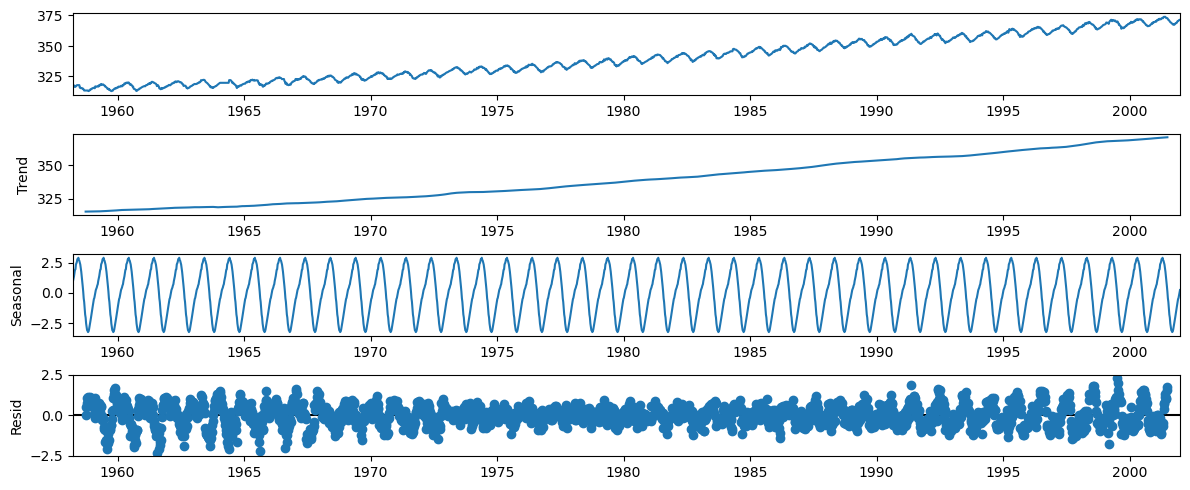

In [12]:
plot = co2_decomposed.plot()

Multiplicative Decomposition:

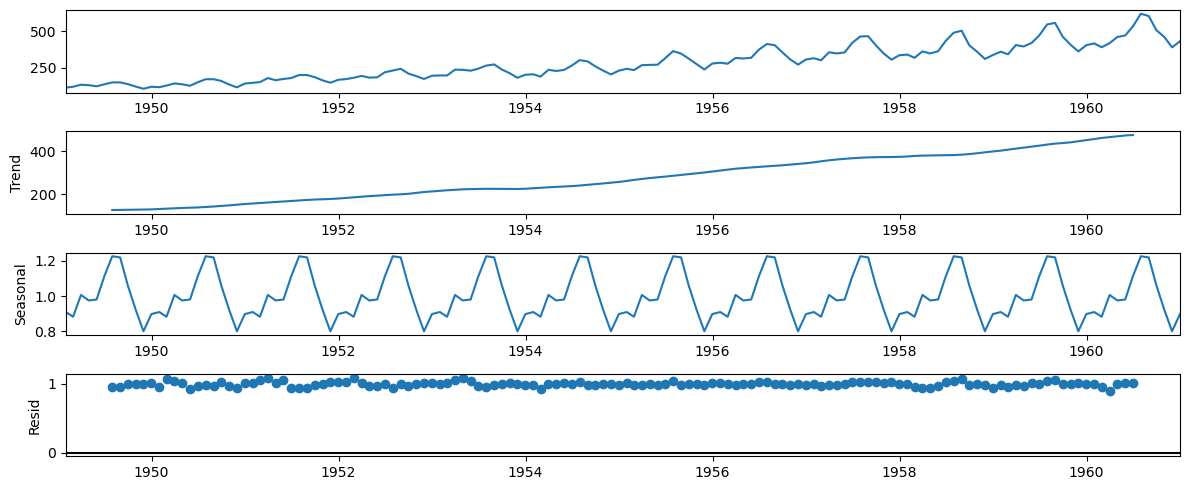

In [13]:
plot = air_decomposed.plot()

Let's break down the resulting plot into four parts: 
1. This is the original observed data that we are decomposing.
2. The trend component shows an upward direction. The trend indicates whether 
there is positive (increasing or upward), negative (decreasing or downward), 
or constant (no trend or horizontal) long-term movement.
3. The seasonal component shows the seasonality effect and the repeating pattern of 
highs and lows.
4. Finally, the residual (noise) component shows the random variation in the data 
after applying the model. In this case, a multiplicative model was used

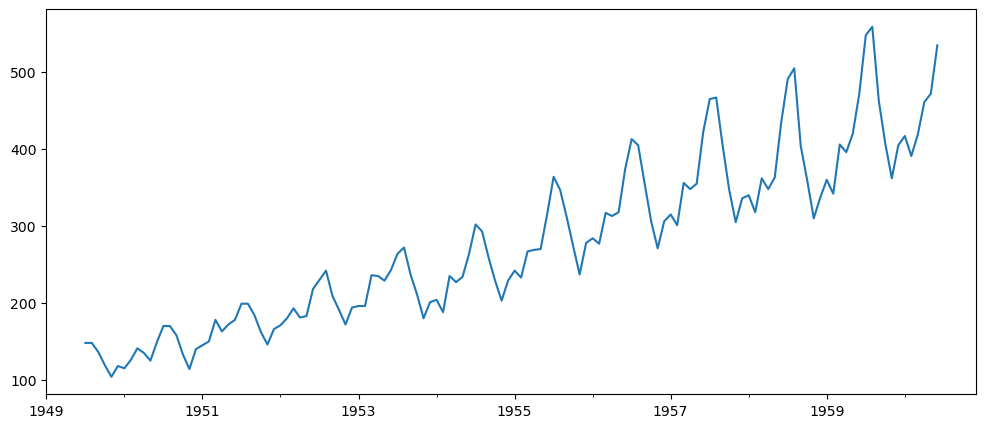

In [14]:
plot = (air_decomposed.trend * 
     air_decomposed.seasonal * 
     air_decomposed.resid).plot()  # multiplying the three components

When **reconstructing the time series**, for example, in a **multiplicative** model, you 
will be multiplying the three components. To demonstrate this concept, use **air_
decomposed**. The class provides the 
seasonal, trend, and resid attributes as well as the **.plot()** method.

#### Seasonal Trend Decomposition: 
Another decomposition option within statsmodels is **STL**, which is a more 
advanced decomposition technique. In statsmodels, the STL class requires 
additional parameters than the **seasonal_decompose** function. The two other 
parameters you will use are **seasonal** and **robust**. The seasonal parameter is 
for the seasonal smoother and can only take **odd integer values greater than or equal 
to 7**. Similarly, the STL function has a **trend smoother (the trend parameter)**. 

Watch this video first: https://youtu.be/1NXryMoU7Ho

The second parameter is robust, which takes a Boolean value (True or False). 
Setting robust=True helps remove the impact of outliers on seasonal and 
trend components when calculated. You will use STL to decompose the co2_df
DataFrame:

In [15]:
co2_stl = STL(co2_df, seasonal=13, robust=True).fit()

This should produce similar subplots to the seasonal_decompose function, showing 
the trend, seasonality, and residuals:

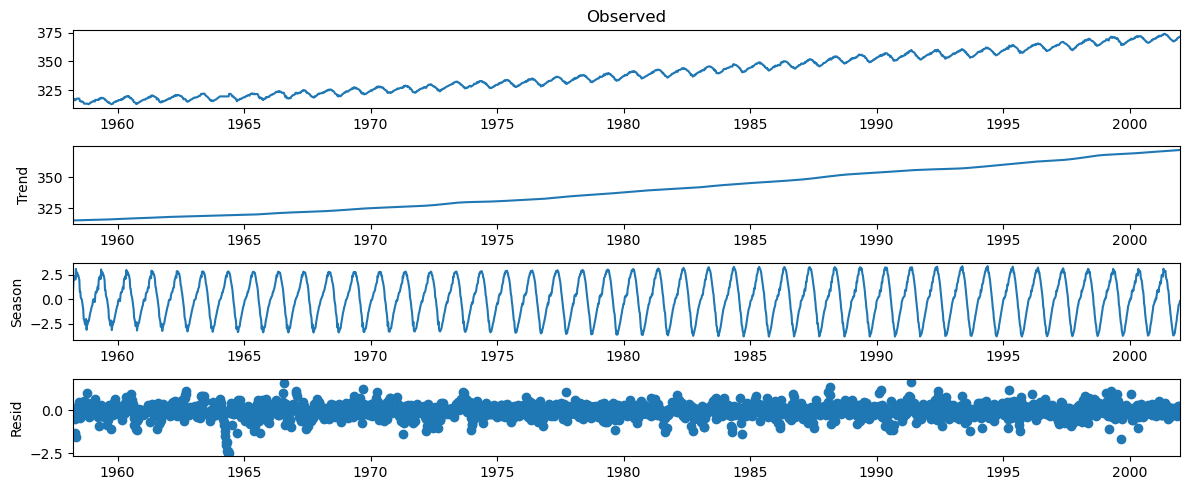

In [16]:
plot = co2_stl.plot()

You will notice that the residual 
plots look different, indicating that both methods capture similar information using 
distinct mechanisms. When you used **STL**, you provided `seasonal=13` because the 
data has an annual seasonal effect.

Explanation: 

You used two different approaches for time series decomposition. Both methods 
decompose a time series into trend, seasonal, and residual components. 
The **STL** class uses the **LOESS seasonal smoother**, which stands for **Locally Estimated 
Scatterplot Smoothing**. 

STL is more robust than seasonal_decompose for measuring 
non-linear relationships. On the other hand, STL assumes additive composition, so you 
do not need to indicate a model, unlike with seasonal_decompose. 


Both approaches can extract seasonality from time series to better observe the overall 
trend in the data.


### HP Filter:

The Hodrick-Prescott filter is a smoothing filter that can be used to separate short-term 
fluctuations (cyclic variations) from long-term trends. This is implemented as hp_
filter in the statsmodels library.

Recall that STL and seasonal_decompose returned three components (trend, 
seasonal, and residual). On the other hand, hp_filter returns two components: 
a cyclical component and a trend component. 

* Theory: https://analyticsindiamag.com/a-complete-guide-to-hodrick-prescott-filter-in-time-series-analysis/ 
* Video: https://youtu.be/G9oI9u6M_Xw 

In [17]:
# plt.rcParams["figure.figsize"] = (20,3)
from statsmodels.tsa.filters.hp_filter import hpfilter

In [18]:
hpfilter(co2_df)

(1958-03-29   -1.559479
 1958-04-05   -0.285928
 1958-04-12    0.088597
 1958-04-19    0.065250
 1958-04-26   -0.954871
                 ...   
 2001-12-01    0.619135
 2001-12-08    0.969594
 2001-12-15    1.215590
 2001-12-22    1.159358
 2001-12-29    1.202375
 Freq: W-SAT, Name: cycle, Length: 2284, dtype: float64,
 1958-03-29    317.659479
 1958-04-05    317.585928
 1958-04-12    317.511403
 1958-04-19    317.434750
 1958-04-26    317.354871
                  ...    
 2001-12-01    369.680865
 2001-12-08    369.830406
 2001-12-15    369.984410
 2001-12-22    370.140642
 2001-12-29    370.297625
 Freq: W-SAT, Name: trend, Length: 2284, dtype: float64)

In [19]:
co2_cyclic, co2_trend = hpfilter(co2_df)

The hpfilter function returns two pandas Series: the first Series is for the cycle and 
the second Series is for the trend. Plot **co2_cyclic** and **co2_trend** side by side to 
gain a better idea of what information the **Hodrick-Prescott filter** was able to extract from 
the data:

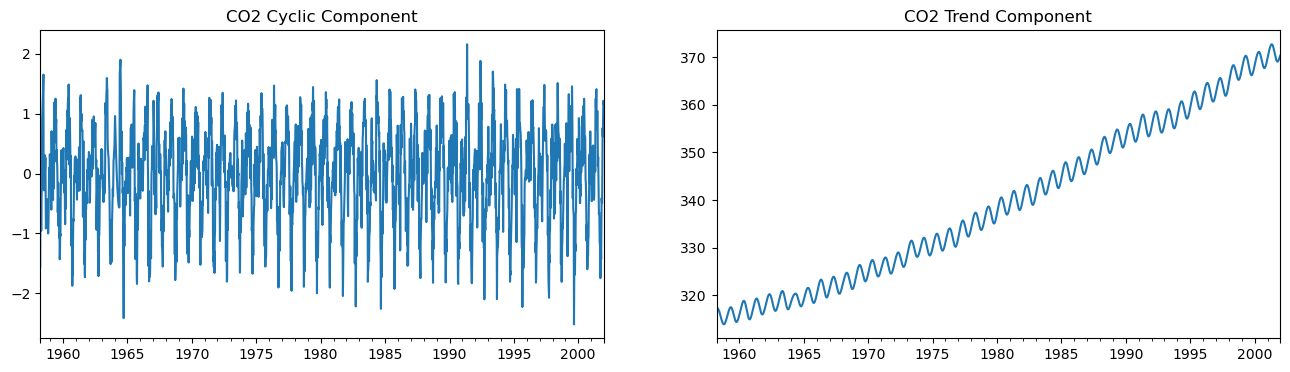

In [20]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 Cyclic Component')
co2_trend.plot(ax=ax[1], title='CO2 Trend Component')
#fig.savefig('images/fig_9.18.png', bbox_inches='tight')

Note that the two components from hp_filter are additive. In other words, to 
reconstruct the original time series, you would add co2_cyclic and co2_trend.


In [21]:
((co2_cyclic + co2_trend) == co2_df['co2']).sum()

2284

In [22]:
co2_df.shape

(2284, 1)

### Stationarity:
Several time series forecasting techniques assume **stationarity**. This makes it essential to 
understand whether the time series you are working with is **stationary** or **non-stationary**. 

A stationary time series implies that specific statistical properties do not vary over time 
and remain steady, making the processes easier to model and predict. On the other 
hand, a non-stationary process is more complex to model due to the dynamic nature and 
variations over time (for example, in the presence of trend or seasonality). 

There are different approaches for defining stationarity; some are strict and may not be 
possible to observe in real-world data, referred to as *strong stationarity*. In contrast, other 
definitions are more modest in their criteria and can be observed in (or transformed into) 
real-world data, known as *weak stationarity*.

In this topic, and for practical reasons, a stationary time series is defined as a time 
series with a **constant mean(μ), a constant variance (σ2) , and a consistent covariance 
(or autocorrelation) between identical distanced periods (lags)**. Having the mean and 
variance as constants simplifies modeling since you are not solving for them as functions 
of time.

Generally, a time series with trend or seasonality can be considered non-stationary. Usually, 
spotting trends or seasonality visually in a plot can help you determine whether the time 
series is stationary or not. In such cases, a simple line plot would suffice. But in this recipe, 
you will explore statistical tests to help you identify a stationary or non-stationary time 
series numerically. You will explore testing for stationarity and techniques for making 
a time series stationary.

### Detecting Time Series Stationarity:

* Video Resource: https://youtu.be/aIdTGKjQWjA , https://youtu.be/oY-j2Wof51c , https://youtu.be/warCSvy1DMk 
* Theory Resource: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

You will explore two statistical tests, the **Augmented Dickey-Fuller (ADF) test** and the 
**Kwiatkowski-Phillips-Schmidt-Shin (KPSS)** test, using the statsmodels library. Both 
ADF and KPSS test for unit roots in a univariate time series process. Note that unit roots 
are just one cause for a time series to be non-stationary, but generally, the presence of unit 
roots indicates non-stationarity. 

Both ADF and KPSS are based on linear regression and are a type of statistical hypothesis 
test. For example, the **null hypothesis** for ADF states that there is a unit root in the 
time series, and thus, it is non-stationary. On the other hand, KPSS has the opposite 
null hypothesis, which assumes the time series is stationary. Therefore, you will need 
to interpret the test results to determine whether you can reject or fail to reject the null 
hypothesis. Generally, you can rely on the p-values returned to decide whether you reject 
or fail to reject the null hypothesis. Remember, the interpretation for ADF and KPSS 
results is different given their opposite null hypotheses.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.datasets import co2
import warnings

In addition to the **visual interpretation of a time series plot to determine stationarity**, 
a more concrete method would be to use one of the unit root tests, such as the ADF 
KPSS test. 

In below figure, you can spot an upward trend and a reoccurring seasonal pattern (annual). 
However, when trend or seasonality exists (in this case, both), it makes the time series 
non-stationary. It's not always this easy to identify stationarity or lack of it visually, and 
therefore, you will rely on statistical tests. 

You will use both the `adfuller` and `kpss` tests from the statsmodels library and 
interpret their results knowing they have opposite null hypotheses:

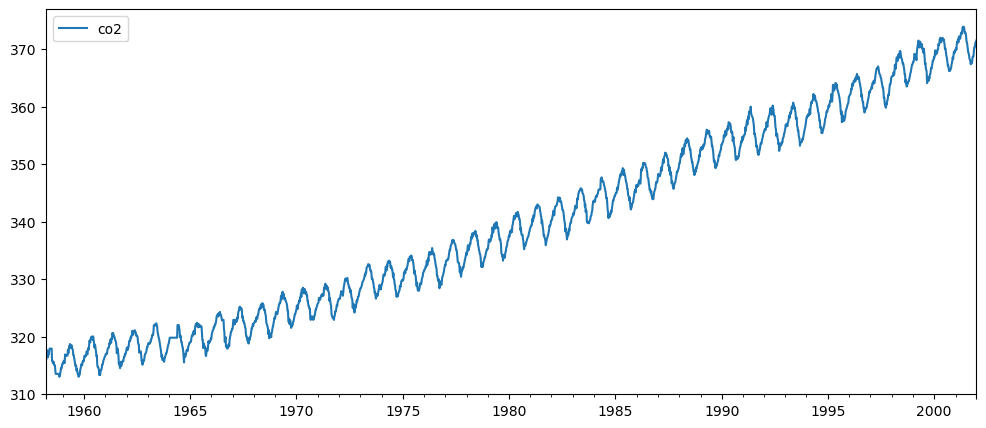

In [24]:
co2_df.plot()

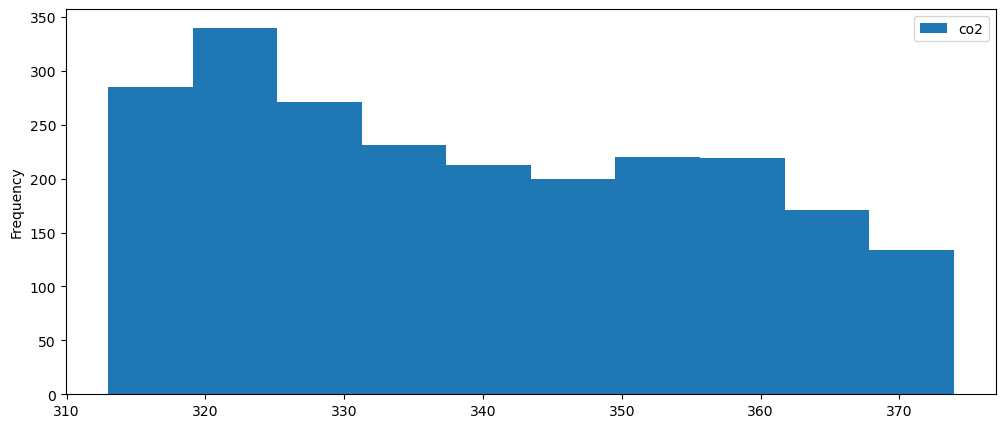

In [25]:
co2_df.plot(kind='hist')

In [26]:
co2_df.shape

(2284, 1)

In [30]:
n = co2_df.shape[0]
lags = int(12*(n/100)**(0.25))

To simplify the interpretation of the test results, create a function that outputs the 
results in a user-friendly way. Let's call the function `print_results`:

The function takes the output from the adfuller and kpss functions and returns 
a dictionary that adds labels to the output. 

In [31]:
# use this instead 
def print_results(output, test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

 Run both the kpss and adfuller tests. Use the default parameter values for 
both functions:

In [32]:
adf_output = adfuller(co2_df)
kpss_output = kpss(co2_df)

c:\Users\mailt\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
c:\Users\mailt\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Pass both outputs to the print_results function and concatenate them into 
a pandas DataFrame for easier comparison:

In [33]:
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,0.0460511,8.18319
p-value,0.962179,0.01
Numbers of lags,27,27
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.43325,0.739
Critical Value (5%),-2.86282,0.463
Critical Value (10%),-2.56745,0.347
Critical Value (2.5%),NaN,0.574


For ADF, the p-value is at 0.96, which is greater than 0.05, so you cannot reject
the null hypothesis, and therefore, the time series is non-stationary. For KPSS, the 
p-value is at 0.01, which is less than 0.05, so you reject the null hypothesis, and 
therefore, the time series is non-stationary. 

You will explore six techniques for making the time series stationary, such as 
transformations and differencing. The techniques covered are **first-order differencing, 
second-order differencing, subtracting moving average, log transformation, 
decomposition, and Hodrick-Prescott filter.**

Essentially, stationarity can be achieved by removing trend (detrending) and seasonality 
effects. For each transformation, you will run the stationarity tests and compare the results 
between the different techniques. To simplify the interpretation and comparison, you will 
create two functions: 

In [34]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

`check_stationarity` takes a DataFrame, performs both KPSS and ADF tests, 
and returns the outcome.

In [35]:
def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type, 
                    ax=ax[v,r], 
                    legend=False, 
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(52).mean().plot(ax=ax[v,r], legend=False)
        

**plot_comparison** takes a list of methods and compares their plots. The 
function takes plot_type, so you can explore a line chart and a histogram. The 
function calls the **check_stationarity** function to capture the results for the 
subplot titles.

### Methods for making time series stationary: 

Let's implement some of the methods for making the time series stationary or extracting 
a stationary component. Then, combine the methods into a Python list:

1. **First-order differencing**: Also known as detrending, which is calculated by 
subtracting an observation at time t from the previous observation at time t-1
($$𝑦_𝑡 − 𝑦_{𝑡−1}$$). In pandas this can be done using the `.diff()` function, which defaults 
to `period=1`. Note that the differenced data will contain one less data point (row) 
than the original data, hence the use of the `.dropna()` method:


In [86]:
# using first order differencing (detrending)
first_ord_diff = co2_df.diff().dropna()

2. **Second-order differencing**: This is useful if seasonality exists or if the first-order 
differencing was insufficient. This is essentially differencing twice – differencing to 
remove seasonality followed by differencing to remove trend:

In [87]:
# using second order differencing
second_ord_diff = co2_df.diff().diff().dropna()

In [88]:
# differencing to remove seasonality
diseasonalize = co2_df.diff(52).dropna()

3. **Subtracting moving average** (rolling window) from the time series using 
DataFrame.rolling(window=52).mean() since it is weekly data:

In [89]:
# using rolling mean 
rolling_mean = co2_df.rolling(window=52).mean()
subt_roll_mean = co2_df - rolling_mean

4. **Log transformation** using np.log() is a common technique to stabilize the 
variance in a time series and sometimes enough to make the time series stationary. 
Simply, all it does is replace each observation with its log value:

In [90]:
# log transform
log_transform = np.log(co2_df)

In [91]:
# Square root transform
square_root = np.sqrt(co2_df)

5. Using **time series decomposition** to remove the trend component, such as 
seasonal_decompose. From, it seems the process is additive. This is 
the default parameter in seasonal_decompose, so you do not need to make any 
changes here:

In [92]:
# using seasonal_decompose to remove trend
decomp = seasonal_decompose(co2_df)
sd_detrend = (decomp.observed - decomp.trend)

6. Using the **Hodrick-Prescott filter** to remove the trend component, for example, 
using hp_filter:

In [93]:
# using hp_filter 
cyclic_extract, trend = hpfilter(co2_df)

Now, let's combine the methods into a Python list, then pass the list to the plot_
comparison function:

In [94]:
# combine the methods into a list
methods = [first_ord_diff, second_ord_diff, 
           diseasonalize, subt_roll_mean, 
           log_transform, square_root,
           sd_detrend, cyclic_extract]

In [95]:
plt.rcParams["figure.figsize"] = [12, 5]

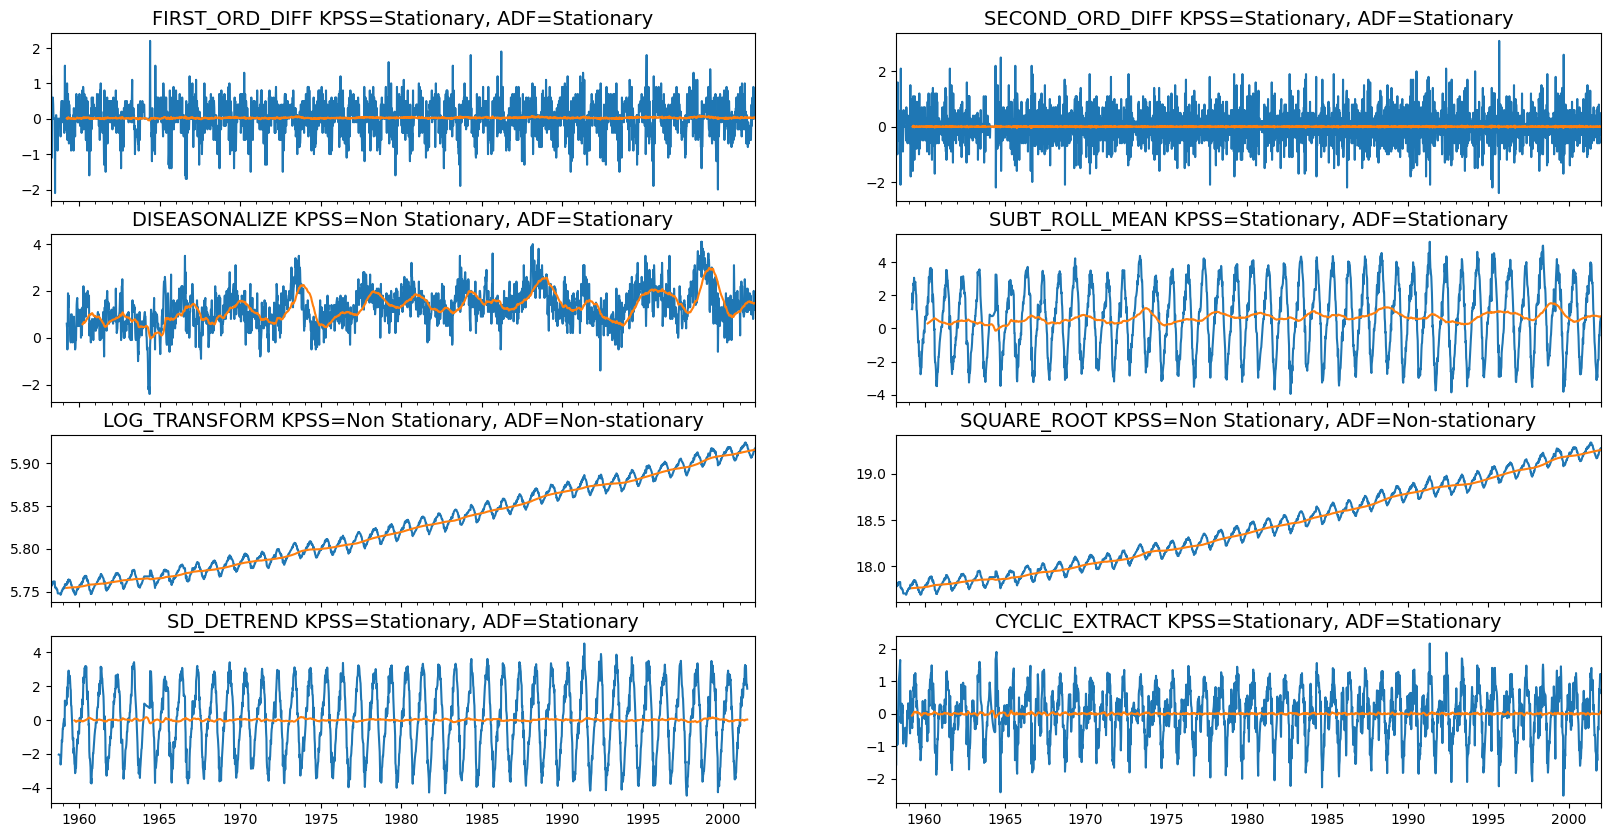

In [40]:
plot = plot_comparison(methods)
warnings.simplefilter('ignore')

Generally, you do not want to over-difference your time series as some studies have shown 
that models based on over-differenced data are less accurate. For example, **first_
order_diff** already made the time series stationary, and thus there was no need to 
difference it any further. In other words, **differencing_twice** was not needed. 
Additionally, notice how **log_transform** is still non-stationary. 

Notice the center line representing the **time series average (moving average)**. The mean 
should be constant for a stationary time series and look more like a straight line.


Stationarity is an essential concept in time series forecasting, and more relevant when 
working with financial or economic data. The mean is considered stable and constant if 
the time series is stationary. In other words, there is an equilibrium as values may deviate 
from the mean (above or below), but eventually, it always returns to the mean. Some 
trading strategies rely on this core assumption, formally called a **mean reversion** strategy.

The statsmodels library offers stationarity tests, such as the adfuller and kpss
functions. Both are considered unit root tests and are used to determine whether 
differencing or other transformations are needed to make the time series stationary. 

Remember, ADF and KPSS tests are based on different null hypotheses. For example, 
adfuller and kpss have an opposite null hypothesis. So, the p-value that you use to 
reject (or fail to reject) the null hypothesis will be interpreted differently between the two.

In [96]:
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,0.0460511,8.18319
p-value,0.962179,0.01
Numbers of lags,27,27
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.43325,0.739
Critical Value (5%),-2.86282,0.463
Critical Value (10%),-2.56745,0.347
Critical Value (2.5%),NaN,0.574


There is additional information returned by the tests. This includes the following:
* The Test Statistic value is 0.046 for ADF and 8.18 for KPSS, which are above 
the 1% critical value threshold. This indicates that the time series is non-stationary. 
It confirms that you cannot reject the null hypothesis. The critical values for ADF 
come from a Dickey-Fuller table. Luckily, you do not have to reference the Dickey-Fuller table since all statistical software/libraries that offer the ADF test use the table 
internally. The same applies to KPSS.

* The p-value result is associated with the test statistic. Generally, you can reject the 
null hypothesis if the p-value is less than 0.05 (5%). Again, when using ADF, KPSS, 
or other stationarity tests, make sure to understand the null hypothesis to accurately 
interpret the results. 

* Number of lags represents the number of lags used in the autoregressive 
process in the test (ADF and KPSS). In both tests, 27 lags were used. Since our 
CO2 data is weekly, a lag represents 1 week back. So, 27 lags represent 27 weeks in 
our data.
* The number of observations used is the number of data points, excluding the 
number of lags.
* The maximized info criteria are based on the autolag parameter. The default 
is **autolag="aic"** for the Akaike information criterion. Other acceptable autolag parameter values are bic for the Bayesian information criterion
and t-stat.


#### How many times to perform differencing? 
In the presence of seasonal 
patterns you will need to remove the seasonal effect as well, which can be done through 
seasonal differencing. This is done in addition to the first-order differencing for detrending; 
hence it can be called second-order differencing, twice-differencing, or differencing twice 
as you use differencing to remove seasonality effect first and again to remove the trend. 
This assumes the seasonal differencing was insufficient to make the time series stationary. 
Your goal is to use the minimal amount of differencing needed and avoid over-differencing. 
You will rarely need to go beyond differencing twice.

#### Ordinary Least Squares (OLS) regression in ADF and KPSS


we mentioned that both ADF and KPSS use 
Ordinary Least Squares (OLS) regression. More specifically, OLS regression is used to 
compute the model's coefficients. To view the OLS results for ADF, you use the store
parameter and set it to `True`:

In [41]:
adf_result = adfuller(first_ord_diff, store=True)

The preceding code will return a tuple that contains the test results. The regression 
summary will be appended as the last item. There should be four items in the tuple: the 
first item, adf_result[0], contains the t-statistic, the second item, adf_result[1], 
includes the p-value, and the third item, adf_result[2], contains the critical values for 
1%, 5%, and 10% intervals. The last item, adf_result[3], includes a ResultStore
object. 

In [42]:
adf_result

(-15.51747204598897,
 2.3063609140308353e-28,
 {'1%': -3.4332532193008443,
  '5%': -2.862822565622804,
  '10%': -2.5674527697012306},
 <statsmodels.stats.diagnostic.ResultsStore at 0x19fec0588b0>)

In [43]:
adf_result[3]

You can access the last item by using adf_result[-1], as shown in the 
following code. The ResultStore object gives you access to .resols, which contains the 
**.summary()** method. This should produce the following output:

In [44]:
adf_result[-1].resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     112.4
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        11:18:05   Log-Likelihood:                -1300.1
No. Observations:                2255   AIC:                             2658.
Df Residuals:                    2226   BIC:                             2824.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2089      0.078    -15.517      0.000      -1.362      -1.056
x2             0.0694      0.074      0.934      0.351      -0.076       0.215
x3             0.0549      0.071      0.771      0.441      -0.085       0.194
x4             0.2661      0.068      3.894      0.000       0.132       0.400
x5             0.4363      0.066      6.603      0.000       0.307       0.566
x6             0.6273      0.064      9.780      0.000       0.502       0.753
x7             0.7159      0.063     11.377      0.000       0.592       0.839
x8             0.8211      0.062     13.246      0.000       0.699       0.943
x9             0.8455      0.061     13.779      0.000       0.725       0.966
x10            0.8269      0.061     13.641      0.000       0.708       0.946
x11            0.7763      0.060     13.011      0.000       0.659       0.893
x12            0.6904      0.058     11.815      0.000       0.576       0.805
x13            0.5949      0.057     10.486      0.000       0.484       0.706
x14            0.4798      0.055      8.736      0.000       0.372       0.588
x15            0.3971      0.053      7.466      0.000       0.293       0.501
x16            0.3136      0.052      6.074      0.000       0.212       0.415
x17            0.2572      0.050      5.096      0.000       0.158       0.356
x18            0.2521      0.050      5.082      0.000       0.155       0.349
x19            0.2443      0.049      4.982      0.000       0.148       0.341
x20            0.2534      0.049      5.211      0.000       0.158       0.349
x21            0.2867      0.048      5.940      0.000       0.192       0.381
x22            0.3286      0.048      6.864      0.000       0.235       0.422
x23            0.3501      0.047      7.426      0.000       0.258       0.443
x24            0.3452      0.046      7.504      0.000       0.255       0.435
x25            0.3440      0.044      7.904      0.000       0.259       0.429
x26            0.2724      0.039      6.924      0.000       0.195       0.350
x27            0.1844      0.032      5.846      0.000       0.123       0.246
x28            0.0940      0.021      4.493      0.000       0.053       0.135
const          0.0299      0.009      3.201      0.001       0.012       0.048
==============================================================================
Omnibus:                       57.058   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.961
Skew:                           0.023   Prob(JB):                     2.21e-29
Kurtosis:                       4.184   Cond. No.                         27.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

In [45]:
adf_result = adfuller(co2_df ,store=True)
adf_result[-1].resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     24.42
Date:                Wed, 31 May 2023   Prob (F-statistic):          1.63e-108
Time:                        11:18:06   Log-Likelihood:                -1310.4
No. Observations:                2256   AIC:                             2679.
Df Residuals:                    2227   BIC:                             2845.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.512e-05      0.001      0.046      0.963      -0.001       0.001
x2            -0.1320      0.021     -6.248      0.000      -0.173      -0.091
x3            -0.0062      0.021     -0.294      0.769      -0.048       0.035
x4             0.2200      0.021     10.403      0.000       0.178       0.261
x5             0.1717      0.022      7.932      0.000       0.129       0.214
x6             0.1930      0.022      8.799      0.000       0.150       0.236
x7             0.0872      0.022      3.911      0.000       0.044       0.131
x8             0.1022      0.022      4.569      0.000       0.058       0.146
x9             0.0212      0.022      0.944      0.345      -0.023       0.065
x10           -0.0200      0.022     -0.891      0.373      -0.064       0.024
x11           -0.0504      0.022     -2.244      0.025      -0.094      -0.006
x12           -0.0858      0.022     -3.816      0.000      -0.130      -0.042
x13           -0.0909      0.023     -4.034      0.000      -0.135      -0.047
x14           -0.1077      0.023     -4.774      0.000      -0.152      -0.063
x15           -0.0753      0.022     -3.350      0.001      -0.119      -0.031
x16           -0.0725      0.022     -3.238      0.001      -0.116      -0.029
x17           -0.0481      0.022     -2.149      0.032      -0.092      -0.004
x18            0.0024      0.022      0.109      0.913      -0.041       0.046
x19           -0.0042      0.022     -0.187      0.852      -0.048       0.040
x20            0.0103      0.022      0.461      0.645      -0.033       0.054
x21            0.0307      0.022      1.378      0.168      -0.013       0.074
x22            0.0327      0.022      1.474      0.140      -0.011       0.076
x23            0.0134      0.022      0.604      0.546      -0.030       0.057
x24           -0.0227      0.022     -1.042      0.298      -0.065       0.020
x25           -0.0169      0.021     -0.789      0.430      -0.059       0.025
x26           -0.0914      0.021     -4.354      0.000      -0.133      -0.050
x27           -0.0875      0.021     -4.154      0.000      -0.129      -0.046
x28           -0.0781      0.021     -3.726      0.000      -0.119      -0.037
const          0.0187      0.185      0.101      0.919      -0.345       0.382
==============================================================================
Omnibus:                       56.964   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.100
Skew:                           0.046   Prob(JB):                     5.61e-29
Kurtosis:                       4.173   Cond. No.                     6.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

### Applying Power Transformations

Video: https://youtu.be/h4WYX9-um04 

Time series data can be complex, and embedded within the data is critical information 
that you will need to understand and peek into to determine the best approach for 
building a model. For example, you have explored time series decomposition, understood 
the impact of trend and seasonality, and tested for stationarity. In the previous topic, 
**Detecting time series stationarity**, you examined the technique to transform data from 
non-stationary to stationary. This includes the idea of detrending, which attempts 
to stabilize the mean over time. 

Depending on the model and analysis you are pursuing, you may need to test for 
additional assumptions against the observed dataset or the model's residuals. For 
example, testing for homoskedasticity (also spelled homoscedasticity) and normality. 

* Homoskedasticity means that the variance is stable over time. More specifically, it is the 
variance of the residuals. When the variance is not constant, changing over time, we call 
it heteroskedasticity (also spelled heteroscedasticity). 
* Another assumption you will need 
to test for is normality; does the specific observation come from a normal (Gaussian) 
distribution? Sometimes, you may want to check the normality of the residuals as well, 
which can be part of the model diagnostics stage. Therefore, it is important to be aware 
of the assumptions made by specific models or techniques so you can determine which 
test to use and against which dataset. 

If you do not do this, you may end up with a flawed 
model or an outcome that may be overly optimistic or overly pessimistic. 

Additionally, in this topic, you will learn about Box-Cox transformation, which you 
can use to transform the data to satisfy normality and homoskedasticity. Box-Cox 
transformation takes the following form:

if $ \lambda != 0 $
$$ T(x) = (x^{\lambda} - 1)/\lambda $$ 

if $ \lambda = 0 $
$$ T(x) = ln(x) $$ 


The Box-Cox transformation relies on just one parameter, lambda ( λ), and covers 
both logarithm and power transformations. If λ is 0, then you get a natural log 
transformation; otherwise, it's a power transformation. The approach is to try different 
values of 𝜆 and then test for normality and homoskedasticity. For example, the SciPy
library has the boxcox function, and you can specify different λ values using the lmbda
parameter (interestingly, this is how it is spelled in the implementation since lambda is 
a reserved Python keyword). If the lmbda parameter is set to None, the function will find 
the optimal lambda (λ) value for you. 


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, boxcox
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_goldfeldquandt, 
                                   het_white, jarque_bera,
                                   omni_normtest, normal_ad)
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant

In [47]:
# plt.rcParams["figure.figsize"] = (20,8)

### Testing for Normality

* Videos: https://youtu.be/02I84i8Knas , https://youtu.be/AVketBmpUTE
* Shapiro Test: https://www.geeksforgeeks.org/how-to-perform-a-shapiro-wilk-test-in-python/ 
* KS Test: https://www.statology.org/kolmogorov-smirnov-test-python/

Sometimes, you can determine normality and homoskedasticity from plots, for example, 
a histogram or a Q-Q plot. This recipe aims to teach you how to perform these diagnostic 
tests programmatically in Python. In addition, you will be introduced to the White test
and the Breusch-Pagan Lagrange statistical test for homoskedactisity. 

For normality diagnostics, you will explore the Shapiro-Wilk, D'Agostino-Pearson, and 
Kolmogorov-Smirnov statistical tests. Overall, Shapiro-Wilk tends to perform best and 
handles a broader set of cases.

The statsmodels library and the SciPy library have overlapping implementations. 
For example, the **Kolmogorov-Smirnov test** is implemented as **ktest** in SciPy and 
**ktest_normal** in statsmodels. In SciPy, the **D'Agostino-Pearson test** is implemented as 
**normaltest** and the **Shapiro-Wilk** test as **shapiro**:

In [48]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

The normality diagnostic is a statistical test based on a null hypothesis that you need 
to determine whether you can accept or reject. Conveniently, the following tests that 
you will implement have the same null hypothesis. The null hypothesis states that 
the data is normally distributed; for example, you would reject the null hypothesis 
if the p-value is less than 0.05, making the time series not normally distributed. 
Let's create a simple function, is_normal(), that will return either Normal
or Not Normal based on the p-value:

In [49]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

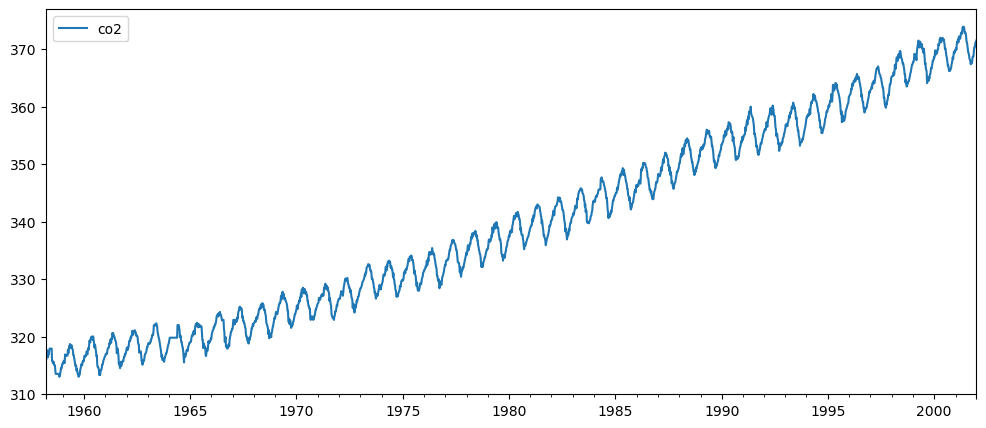

In [50]:
co2_df.plot()

Run each test to check the results:


In [51]:
normal_args = (np.mean(co2_df),np.std(co2_df))

print(is_normal(shapiro(co2_df)))
print(is_normal(normaltest(co2_df)))
print(is_normal(normal_ad(co2_df)))
print(is_normal(kstest_normal(co2_df)))
print(is_normal(kstest(co2_df, 
                   cdf='norm', 
                   args=normal_args)))

Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


he output from the tests confirms the data does not come from a normal 
distribution. You do not need to run that many tests. The shapiro test, for 
example, is a very common and popular test that you can rely on. Generally, 
as with any statistical test, you need to read the documentation regarding the 
implementation to gain an understanding of the test. More specifically, you will 
need to understand the null hypothesis behind the test to determine whether you 
can reject or fail to reject the null hypothesis.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019FF0C848E0>]],
      dtype=object)

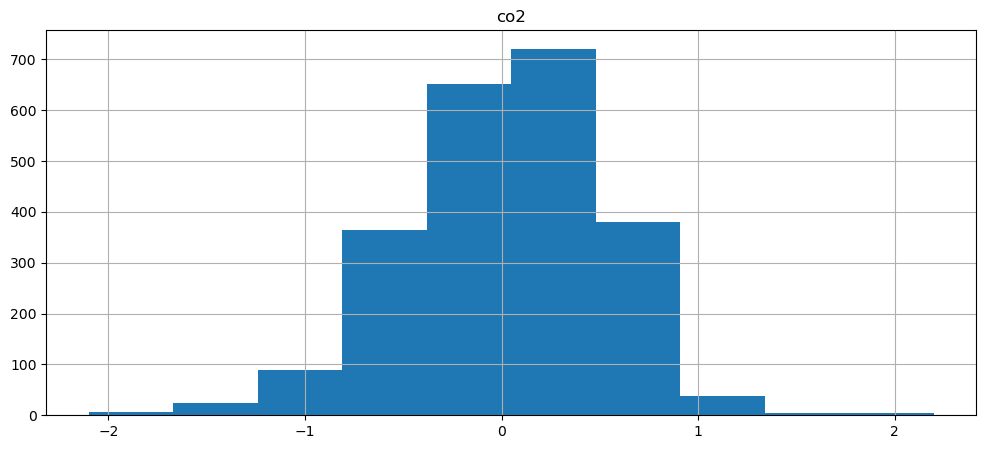

In [52]:
co2_df.diff().hist()

Sometimes, you may need to test normality as part of model evaluation and 
diagnostics. For example, you would evaluate the residuals (defined as the difference 
between actual and predicted values) if they follow a normal distribution. In later notebooks, 
you will explore building forecasting models using autoregressive and moving 
average models. For now, you will run a simple autoregressive (AR(1)) model to 
demonstrate how you can use a normality test against the residuals of a model:

In [53]:
# from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(co2_df.dropna(), lags=1, trend='n').fit()

In [54]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    co2   No. Observations:                 2284
Model:                     AutoReg(1)   Log Likelihood               -1637.977
Method:               Conditional MLE   S.D. of innovations              0.496
Date:                Wed, 31 May 2023   AIC                             -1.401
Time:                        11:29:21   BIC                             -1.396
Sample:                    04-05-1958   HQIC                            -1.399
                         - 12-29-2001                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co2.L1         1.0001   3.05e-05   3.28e+04      0.000       1.000       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9999           +0.0000j            0.9999            0.0000
-----------------------------------------------------------------------------
"""

You can run the shapiro test against the residuals. To access the residuals, 
you would use the .resid property as in model.resid.

In [55]:
print(is_normal(shapiro(model.resid)))
print(is_normal(normaltest(model.resid)))
print(is_normal(normal_ad(model.resid)))
print(is_normal(kstest_normal(model.resid)))
print(is_normal(kstest(model.resid, 
                   cdf='norm', 
                   args=(np.mean(model.resid), np.std(model.resid)))))

Not Normal
Not Normal
Not Normal
Not Normal
Not Normal


The output indicates the residuals are not normally distributed. This fact, residuals not 
being normally distributed, is not enough to determine the model's validity or potential 
improvements. But taken into context with the other tests, it should help you determine 
how good your model is. 

(array([  6.,  25.,  89., 365., 651., 721., 380.,  37.,   5.,   4.]),
 array([-2.12259531, -1.69260882, -1.26262232, -0.83263583, -0.40264933,
         0.02733717,  0.45732366,  0.88731016,  1.31729665,  1.74728315,
         2.17726964]),
 <a list of 10 Patch objects>)

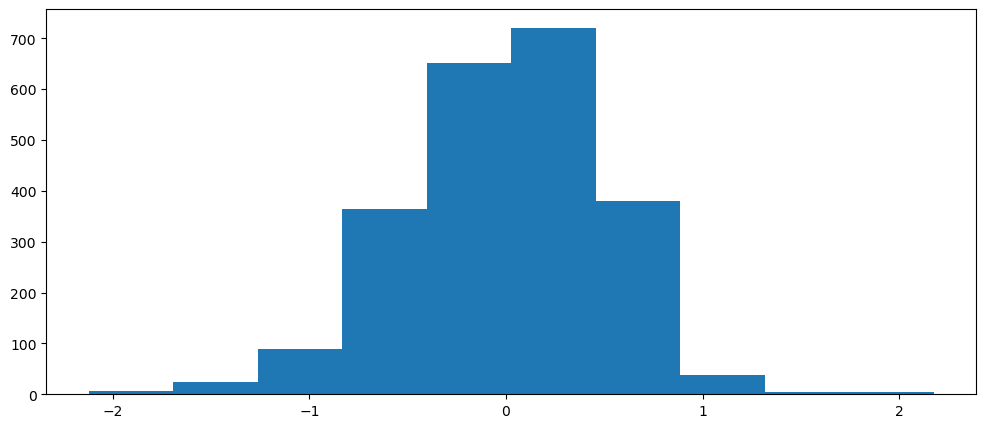

In [56]:
plt.hist(model.resid)

In [57]:
model.resid.mean()

0.00012627220508227264

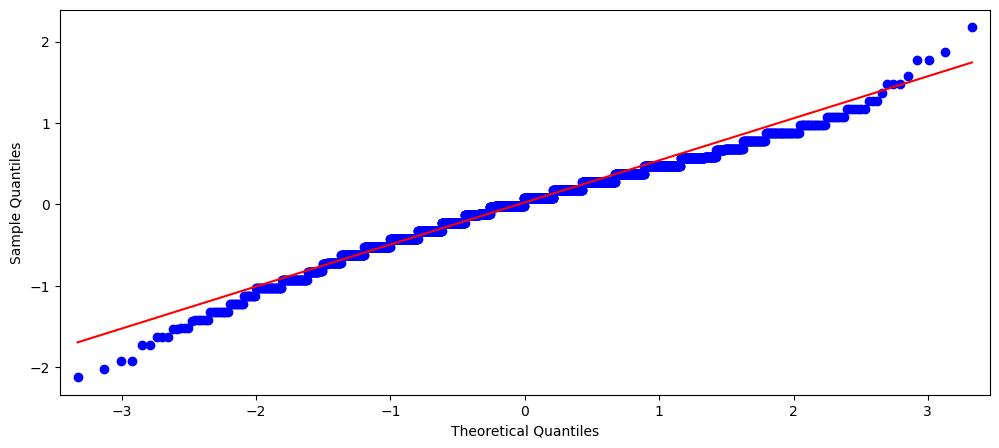

In [58]:
from statsmodels.graphics.gofplots import qqplot
qqplot(model.resid, line='q');

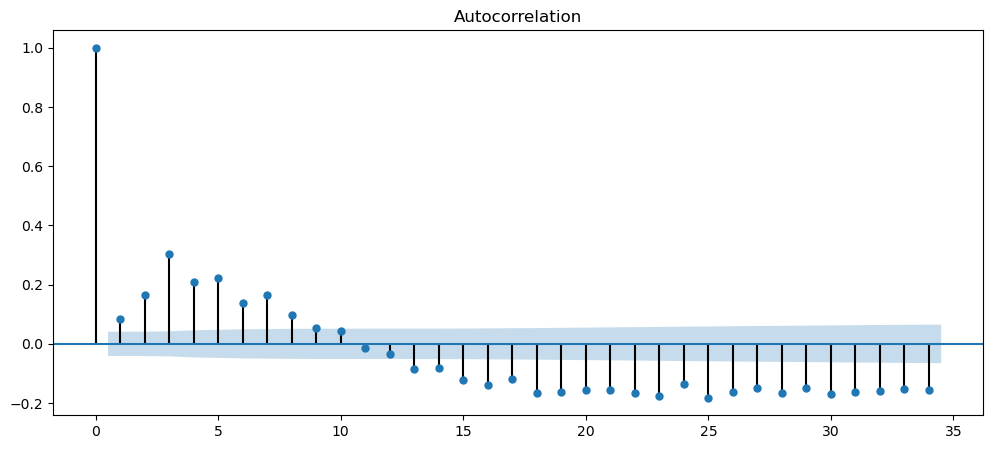

In [59]:
plot_acf(model.resid);plt.show()

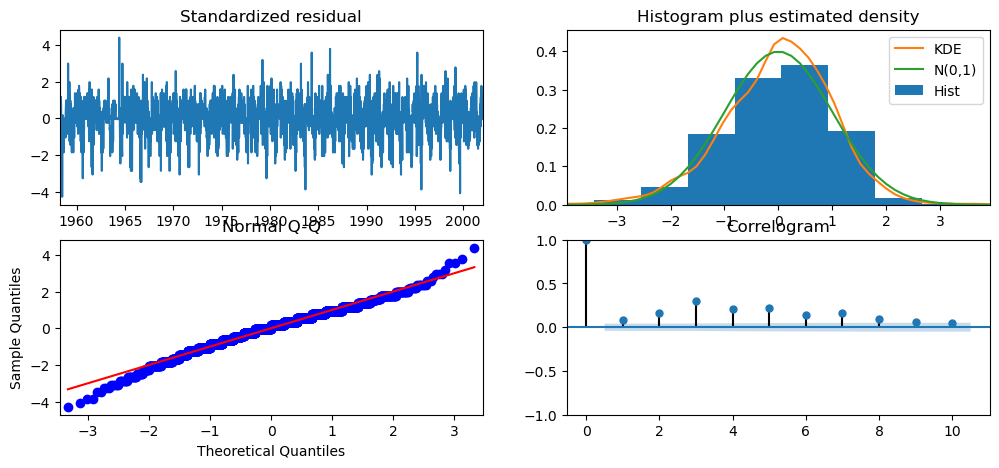

In [60]:
model.plot_diagnostics();plt.show()

In [61]:
model.test_normality()

Jarque-Bera    1.194972e+02
P-value        1.125935e-26
Skewness      -3.395637e-01
Kurtosis       3.891627e+00
dtype: float64

In [62]:
model.test_heteroskedasticity()

,ARCH-LM,P-value,DF
Lag,,,
1,0.590650,0.442168,1
2,2.754957,0.252214,2
3,27.651645,0.000004,3
4,26.480304,0.000025,4
5,30.254785,0.000013,5
6,30.505528,0.000031,6
7,30.480297,0.000078,7
8,30.775329,0.000154,8
9,30.865914,0.000312,9


### Testing Homoskedactiticy

You will be testing for the stability of the variance against the model's residuals. This will 
be the same AR(1) model used in the previous normality test:

In [63]:
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_white)

In [64]:
model.resid

1958-04-05    1.177533
1958-04-12    0.277447
1958-04-19   -0.122574
1958-04-26   -1.122567
1958-05-03    0.477511
                ...   
2001-12-01   -0.026320
2001-12-08    0.473680
2001-12-15    0.373645
2001-12-22    0.073616
2001-12-29    0.173609
Freq: W-SAT, Length: 2283, dtype: float64

In [65]:
model.fittedvalues.shape
model.resid.shape

(2283,)

In [66]:
model.fittedvalues

1958-04-05    316.122467
1958-04-12    317.322553
1958-04-19    317.622574
1958-04-26    317.522567
1958-05-03    316.422489
                 ...    
2001-12-01    370.326320
2001-12-08    370.326320
2001-12-15    370.826355
2001-12-22    371.226384
2001-12-29    371.326391
Freq: W-SAT, Length: 2283, dtype: float64

You will perform a homoskedasticity test on the model's residuals. As stated earlier 
regarding statistical tests, it is vital to understand the hypothesis behind these 
tests. The null hypothesis states that the data is homoskedastic for the two tests. 
For example, you would reject the null hypothesis if the p-value is less than 0.05, 
making the time series heteroskedastic.


Let's create a small function, calling it het_test(model, test), that takes 
in a model and the test function and returns either Heteroskedastic
or Homoskedastic based on the p-value to determine whether the null 
hypothesis is accepted or rejected:

In [67]:
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        het_breuschpagan(model.resid, 
                         add_constant(
                             model.fittedvalues)
                        ))
    
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"

Start with the Breusch-Pagan Lagrange multiplier test to diagnose the residuals. 
In statsmodels, you will use the het_breuschpagan function, which takes 
resid, the model's residual, and exog_het, where you provide the original data 
(explanatory variables) related to the heteroskedasticity in the residual:

In [68]:
het_test(model, test=het_breuschpagan)

'Homoskedastic'

This result indicates that the residual is homoskedastic, with a constant 
variance (stable). 

A very similar test is White's Lagrange multiplier test. In statsmodels, you will use 
the het_white function, which has the same two parameters that you used with 
het_breuschpagan:

In [69]:
het_test(model, test=het_white)

'Homoskedastic'

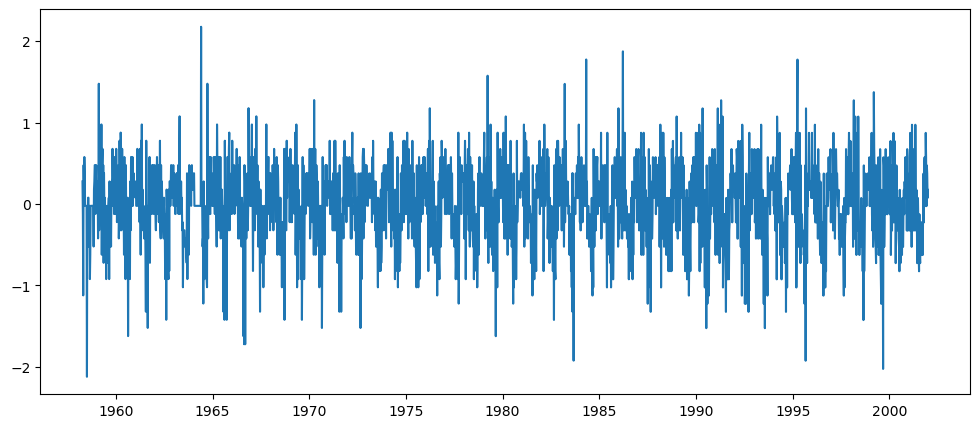

In [70]:
plt.plot(model.resid[1:])

Both tests indicate that the residuals of the autoregressive model have constant variance 
(homoskedastic). Both tests estimate the auxiliary regression against the squared residuals 
and all the explanatory variables.
 
Keep in mind that both normality and homoskedasticity are some of the tests you may 
need to conduct on the residuals as you diagnose your model. Another essential test 
is testing for autocorrelation, which is discussed in the following recipe, Testing for 
autocorrelation in time series data.

### Box-Cox Transformation

Box-Cox transformation can be a useful tool, and it's good to be familiar with. Box-Cox 
transforms a non-normally distributed dataset into a normally distributed one. At the 
same time, it stabilizes the variance, making the data homoskedastic. To gain a better 
understanding of the effect of Box-Cox transformation, you will use the Air Passengers 
dataset, which contains both trend and seasonality:

* Video: https://youtu.be/Vnz1B64xbM4  

1. Start by importing the boxcox function from the SciPy library:


In [71]:
from scipy.stats import boxcox

In [72]:
airp_df

,value
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
...,...
1960-08-31,606
1960-09-30,508
1960-10-31,461
1960-11-30,390


Recall, there is 
a lambda parameter used to determine which transformation to apply (logarithm 
or power transform). Use the boxcox function with the default parameter value for 
lmbda, which is None. Just provide the dataset to satisfy the required x parameter:

In [73]:
xt, lmbda = boxcox(airp_df['value'])

In [74]:
xts = pd.Series(xt, index=airp_df.index)

By not providing a value to lmbda and keeping it at None, the function will find 
the optimal lambda (λ) value. From the introduction of this recipe, you'll remember 
lambda is spelled lmbda in the boxcox implementation. The function returns two 
values captured by xt for the transformed data and lmda for the optimal lambda 
value found. 


Text(0.5, 1.0, 'Box-Cox Transformed')

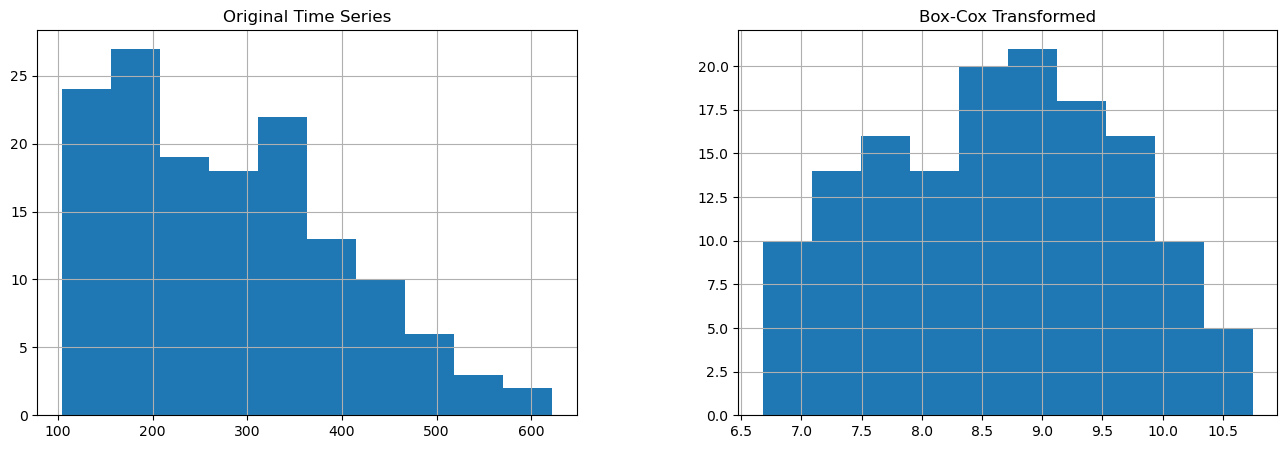

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
airp_df.hist(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.hist(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')

By not providing a value to lmbda and keeping it at None, the function will find 
the optimal lambda (λ) value. From the introduction of this recipe, you'll remember 
lambda is spelled lmbda in the boxcox implementation. The function returns two 
values captured by xt for the transformed data and lmda for the optimal lambda 
value found. 

Plot both datasets to compare before and after the transformation:


Text(0.5, 1.0, 'Box-Cox Transformed')

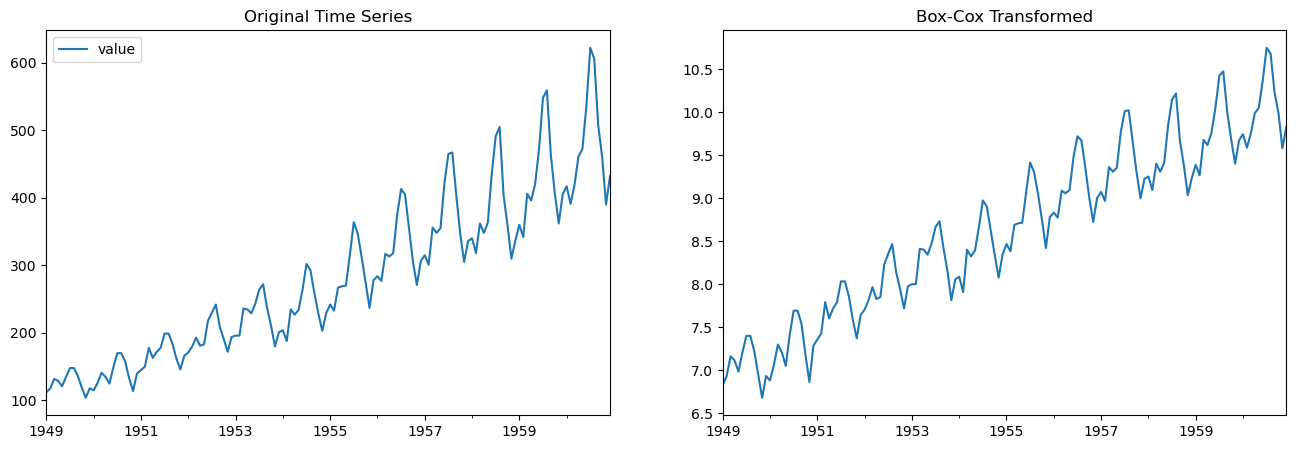

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
airp_df.plot(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.plot(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')
#plt.savefig('images/fig_9.24.png', bbox_inches='tight')

Notice how the seasonal effect on the transformed dataset looks more stable 
than before.

Finally, build two simple autoregressive models to compare the effect on the 
residuals before and after the transformation:

In [78]:
model_airp = AutoReg(airp_df, lags=1, trend='n').fit()
model_bx = AutoReg(xts, lags=1, trend='n').fit()

Text(0.5, 1.0, 'Residual Plot - Box-Cox Transformed')

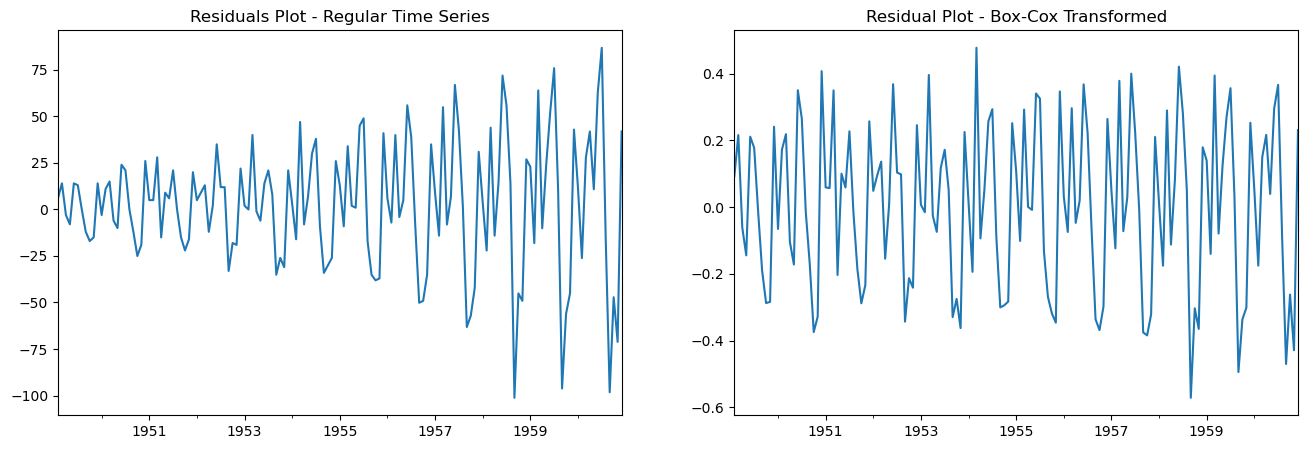

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
model_airp.resid.plot(ax=ax[0])
ax[0].set_title('Residuals Plot - Regular Time Series')
model_bx.resid.plot(ax=ax[1])
ax[1].set_title('Residual Plot - Box-Cox Transformed')
#plt.savefig('images/fig_9.25.png', bbox_inches='tight')

How it works…
Box-Cox allows us to make the data both normal and homoskedastic and is part of 
a family of power transforms that includes log transform and square root transform. 
Box-Cox is a powerful transform because it supports both root and log transforms, and 
others are made possible by changing the lambda values. 

NOTE: One thing to point out is that the boxcox function requires the data to be 
positive. 

### There is more...
The AutoReg model comes with two useful methods: diagnostic_summary() and 
plot_diagnostics(). They will save you time from having to write additional code to
test the model's residuals for normality, homoskedasticity, and autocorrelation. 


The following code shows how you can get the diagnostic summary for model_bx:


In [80]:
print(model_bx.diagnostic_summary())

       Test of No Serial Correlation       
       Lag  Ljung-Box LB P-value         DF
-------------------------------------------
         1      8.800      0.003          1
         2     12.729      0.002          2
         3     28.040      0.000          3
         4     29.202      0.000          4
         5     29.205      0.000          5
         6     31.021      0.000          6
         7     47.992      0.000          7
         8     50.468      0.000          8
         9     52.247      0.000          9
        10     59.828      0.000         10
        11    172.816      0.000         11
        12    181.177      0.000         12


             Test of Normality              
Jarque-Bera    P-value   Skewness   Kurtosis
--------------------------------------------
      5.987      0.050     -0.128      2.031


    Test of Conditional Homoskedasticity   
       Lag    ARCH-LM    P-value         DF
-------------------------------------------
         1      0.116   

The .plot_diagnostics() function will show four plots so you can examine 
the model's residuals. Mainly, the plots will show whether the residuals are normally 
distributed from the Q-Q plot and histogram. Additionally, the autocorrelation function 
plot (ACF) will allow you to examine for autocorrelation.

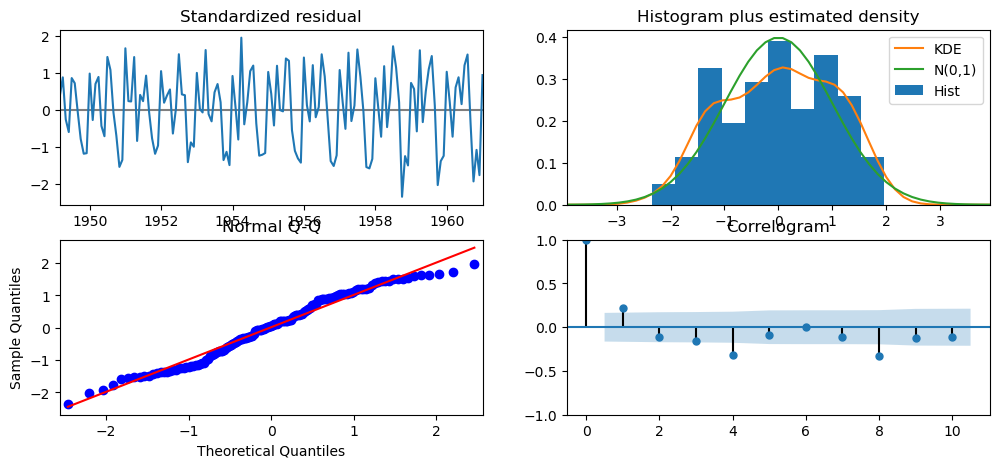

In [81]:
plot = model_bx.plot_diagnostics()
#plt.savefig('images/fig_9.27.png', bbox_inches='tight')


### Autocorrelation and Testing for Autocorrelation:

**Autocorrelation** is like statistical correlation (think Pearson correlation from high 
school), which measures the strength of a linear relationship between two variables, 
except that we measure the linear relationship between time series **values separated by 
a lag**. In other words, we are comparing a variable with its lagged version of **itself**.

Resources for autocorrelation: [this](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/), [this](https://otexts.com/fpp2/autocorrelation.html) and [this](https://towardsdatascience.com/understanding-autocorrelation-in-time-series-analysis-322ad52f2199) - Click any one of these and read it t=completely. 

Videos: https://youtu.be/NaurCbAiD08, https://youtu.be/DeORzP0go5I 


In this topic, you will perform a `Ljung-Box` test to check for autocorrelations up to 
a specified lag and whether they are significantly far off from 0. The null hypothesis for 
the Ljung-Box test states that the previous lags are not correlated with the current period. In 
other words, you are testing for the absence of autocorrelation. 


When running the test using acorr_ljungbox from statsmodels, you need to provide 
a lag value. The test will run for all lags up to the specified lag (maximum lag). 

In [82]:
from statsmodels.stats.diagnostic import acorr_ljungbox

Since the data is not stationary, 
you will perform a log transform this time (log differencing):

In [83]:
co2_diff = co2_df.diff().dropna()

Run the Ljung-Box test. Start with lags=10:

In [84]:
acorr_ljungbox(co2_diff, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,16.465996,4.953050e-05
2,79.094659,6.680563e-18
3,290.951900,9.035108e-63
4,390.520507,3.107289e-83
5,502.638658,2.151267e-106
6,546.194148,9.337537e-115
7,608.250032,4.072029e-127
8,630.709764,5.827742e-131
9,637.510409,1.851867e-131
10,641.806647,1.923859e-131


This shows that the test statistic for all lags up to lag 10 are significant (p-value < 0.05), 
so you can reject the null hypothesis. Rejecting the null hypothesis means you reject the 
claim that there is no autocorrelation. 

acorr_ljungbox is a function that accumulates autocorrelation up until the lag 
specified. Therefore, it is helpful to determine whether the structure is worth modeling in 
the first place.